In [1]:
! pip3 -q install optax equinox

     |████████████████████████████████| 145 kB 4.2 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 85 kB 2.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.2 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
confection 0.0.3 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.


In [2]:
import jax.numpy as jnp
from jax import random, jit, config, vmap
import optax
import matplotlib.pyplot as plt
from functools import partial
config.update("jax_enable_x64", True)

%config InlineBackend.figure_format='retina'

In [3]:
! git init .
! git remote add origin https://github.com/VLSF/SDC
! git pull origin main

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 47 (delta 17), reused 41 (delta 14), pack-reused 0
Unpacking objects: 100% (47/47), done.
From https://github.com/VLSF/SDC
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [4]:
from integrators import RK4, Explicit_Euler, Implicit_Euler
from sdc_integrators import RK4 as RK4_c
from sdc_integrators import Explicit_Euler as Explicit_Euler_c
from sdc_integrators import Implicit_Euler as Implicit_Euler_c
from misc import utils, Chebyshev

# RK4

## $\exp$

In [5]:
exact = lambda x: jnp.expand_dims(jnp.exp(x), -1)
F = jit(lambda u, t: jnp.stack([u[0], ], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

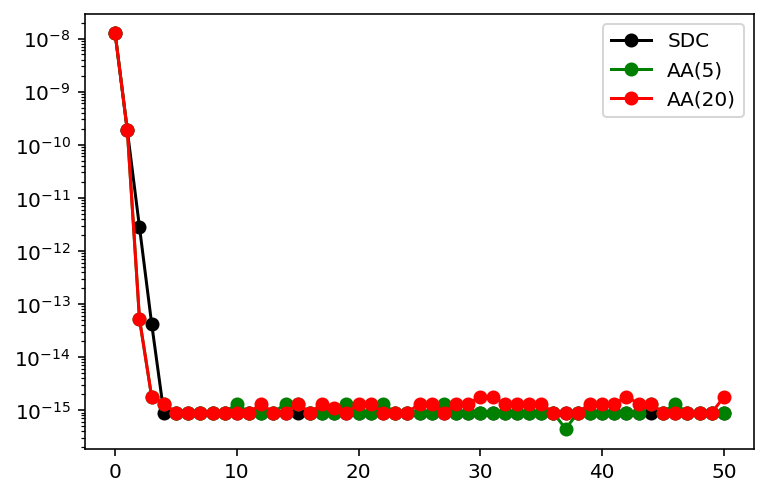

In [6]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## logistic equation

In [7]:
exact = lambda x: jnp.expand_dims(1 / (1 + jnp.exp(-x)), -1)
F = jit(lambda u, t: jnp.stack([u[0] * (1 - u[0]), ], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

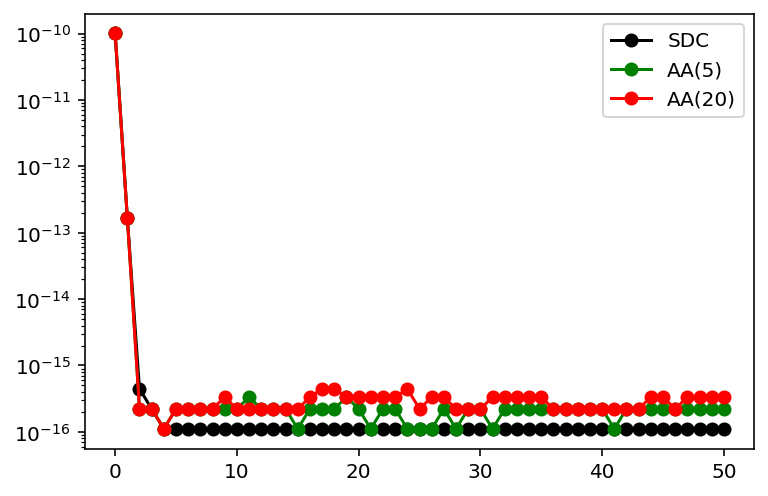

In [8]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## $\cos(\omega x)$

In [9]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = jit(lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

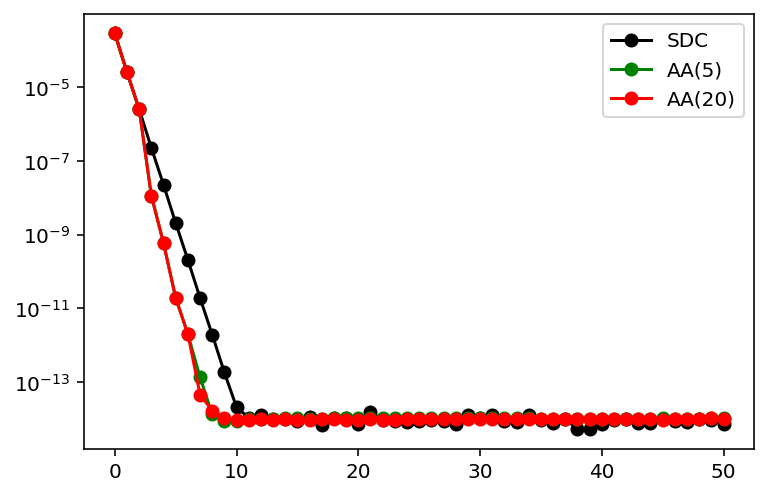

In [10]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## Prothero–Robinson

\begin{equation}
  \dot{y}(t) = \dot{g}(t) + \delta (y(t) - g(t)),\,y(0)=\sigma\,g(t) = \sin(t)
\end{equation}

### $\delta = 0.1$

In [11]:
delta = 0.1
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

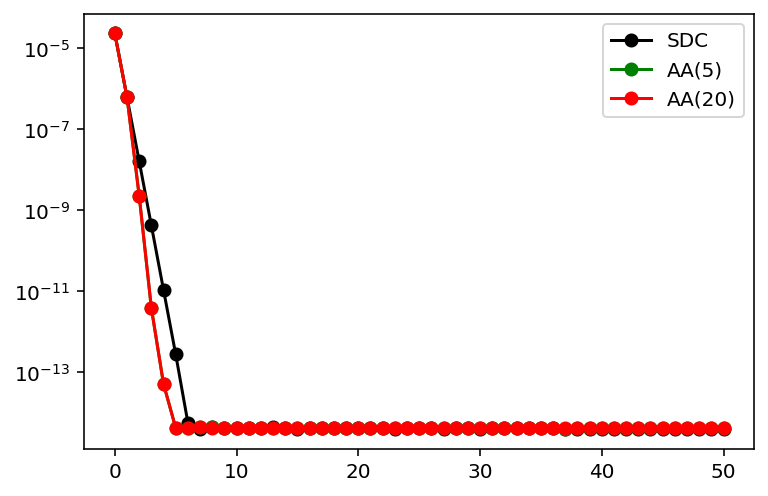

In [12]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 2$

In [13]:
delta = 2
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

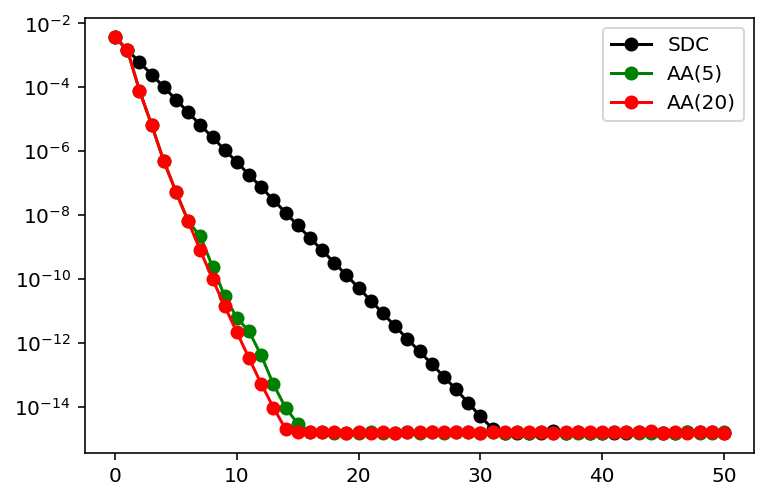

In [14]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 7$

In [15]:
delta = 7
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = RK4_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = RK4.integrator(u0, F, N_points, t0, t1)
U = RK4_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_50 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

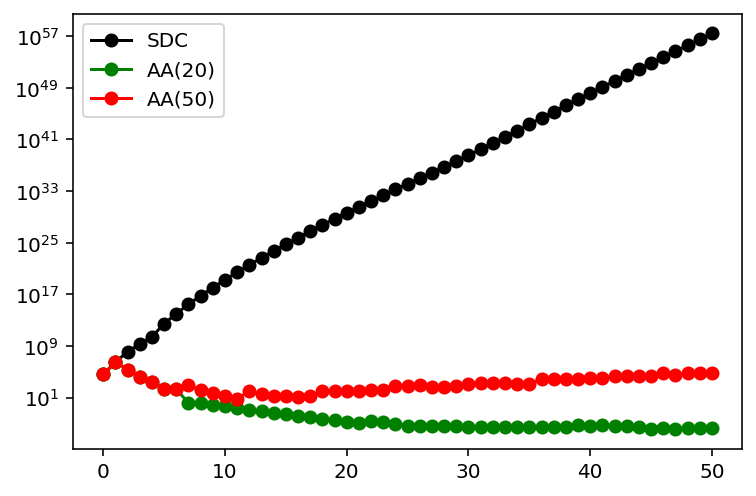

In [16]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_20, "o-", color="green", label="AA(20)")
plt.plot(E_AA_50, "o-", color="red", label="AA(50)")
plt.legend();

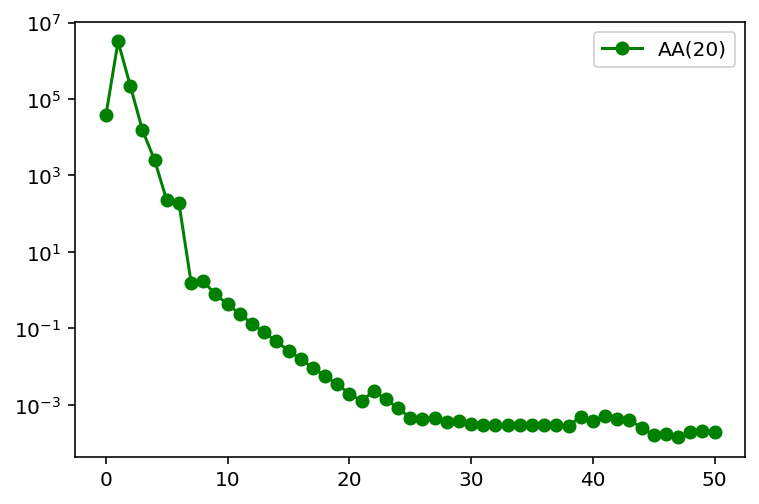

In [17]:
plt.yscale("log")
plt.plot(E_AA_20, "o-", color="green", label="AA(20)")
plt.legend();

# Explicit Euler

## $\exp$

In [18]:
exact = lambda x: jnp.expand_dims(jnp.exp(x), -1)
F = jit(lambda u, t: jnp.stack([u[0], ], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

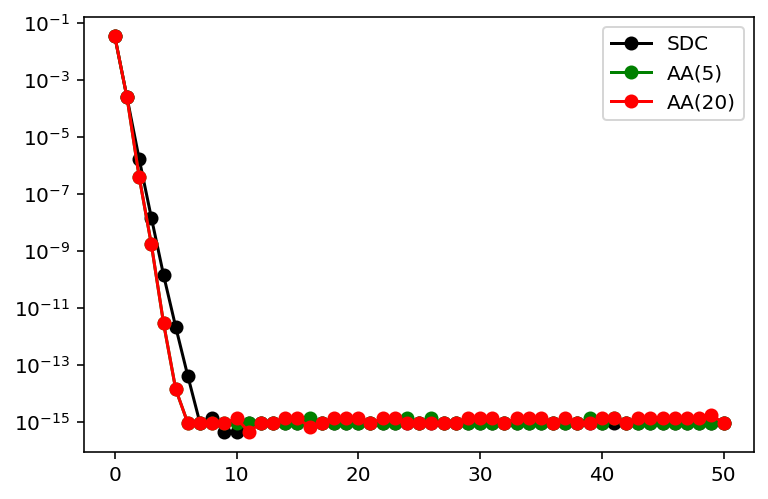

In [19]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## logistic equation

In [20]:
exact = lambda x: jnp.expand_dims(1 / (1 + jnp.exp(-x)), -1)
F = jit(lambda u, t: jnp.stack([u[0] * (1 - u[0]), ], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

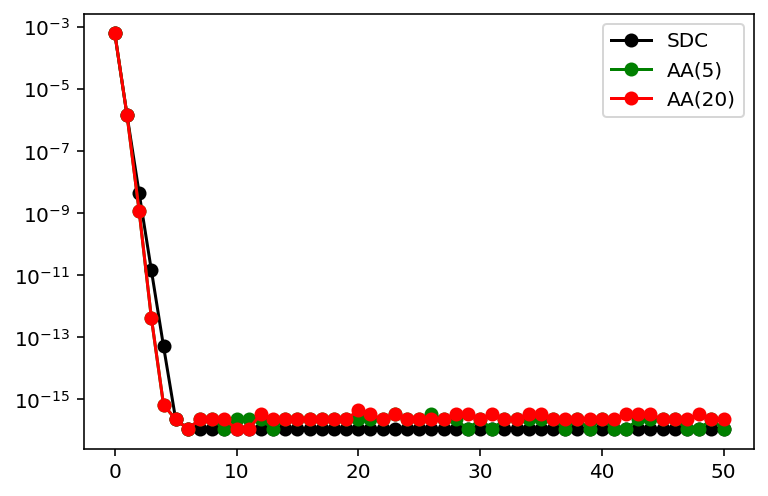

In [21]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## $\cos(\omega x)$

In [22]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = jit(lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

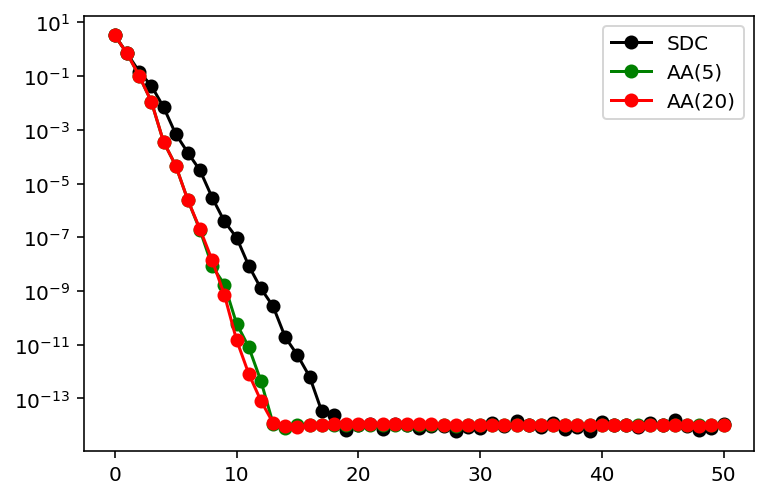

In [23]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## Prothero–Robinson

\begin{equation}
  \dot{y}(t) = \dot{g}(t) + \delta (y(t) - g(t)),\,y(0)=\sigma\,g(t) = \sin(t)
\end{equation}

### $\delta = 0.1$

In [24]:
delta = 0.1
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

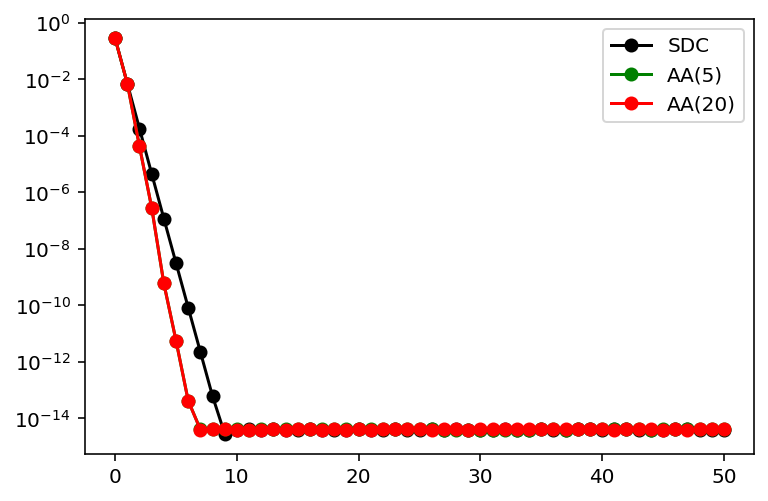

In [25]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 2$

In [26]:
delta = 2
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = RK4.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

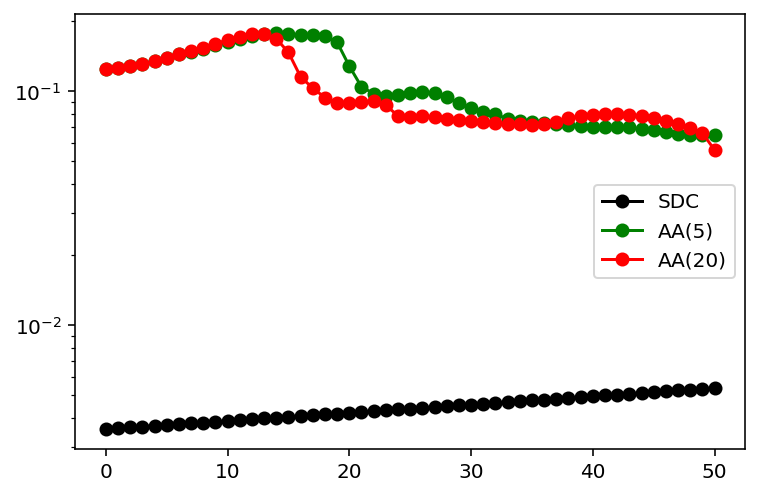

In [27]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 7$

In [28]:
delta = 10
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Explicit_Euler_c.deferred_correction(values, F, t0, t1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Explicit_Euler.integrator(u0, F, N_points, t0, t1)
U = Explicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1)
E_AA_50 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

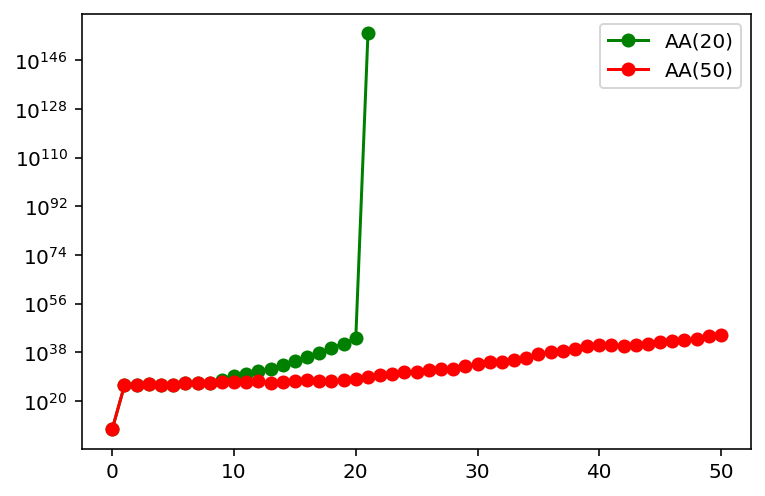

In [29]:
plt.yscale("log")
# plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_20, "o-", color="green", label="AA(20)")
plt.plot(E_AA_50, "o-", color="red", label="AA(50)")
plt.legend();

# Implicit Euler

## $\exp$

In [30]:
exact = lambda x: jnp.expand_dims(jnp.exp(x), -1)
F = lambda u, t: jnp.stack([u[0], ], -1)

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

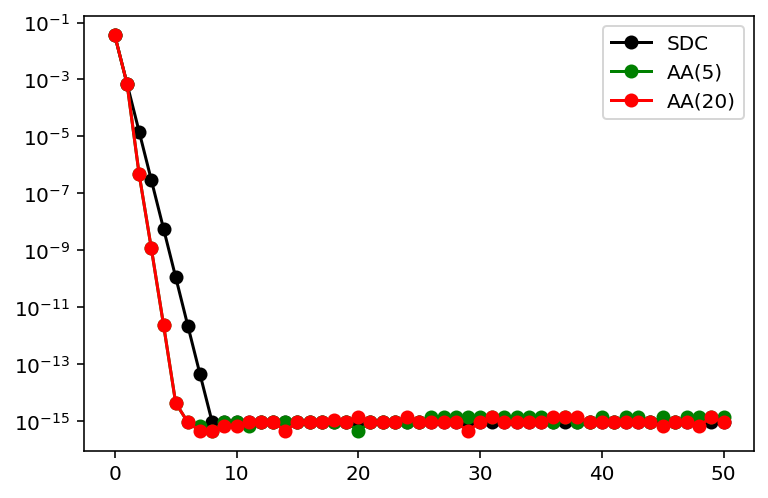

In [31]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## logistic equation

In [32]:
exact = lambda x: jnp.expand_dims(1 / (1 + jnp.exp(-x)), -1)
F = jit(lambda u, t: jnp.stack([u[0] * (1 - u[0]), ], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

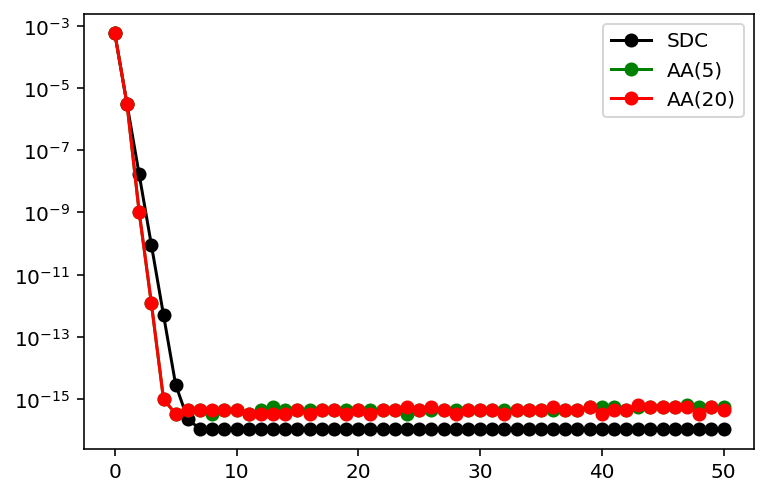

In [33]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## $\cos(\omega x)$

In [34]:
exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = jit(lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

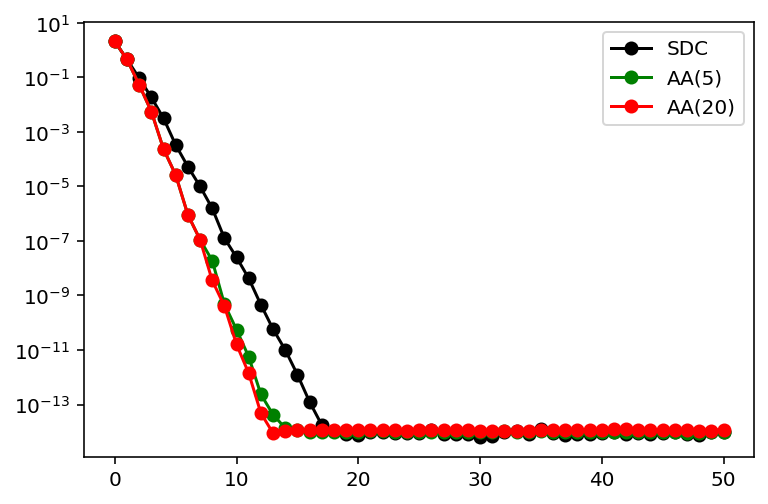

In [35]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## Prothero–Robinson

\begin{equation}
  \dot{y}(t) = \dot{g}(t) + \delta (y(t) - g(t)),\,y(0)=\sigma\,g(t) = \sin(t)
\end{equation}

### $\delta = 0.1$

In [36]:
delta = 0.1
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

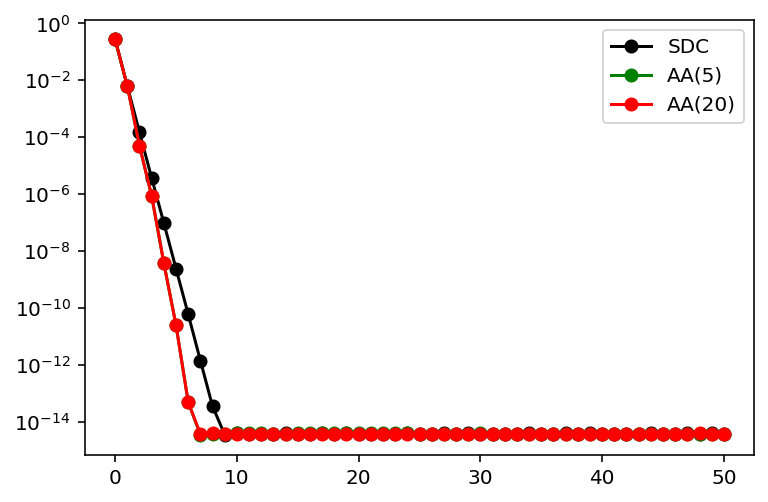

In [37]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 2$

In [38]:
delta = 2
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

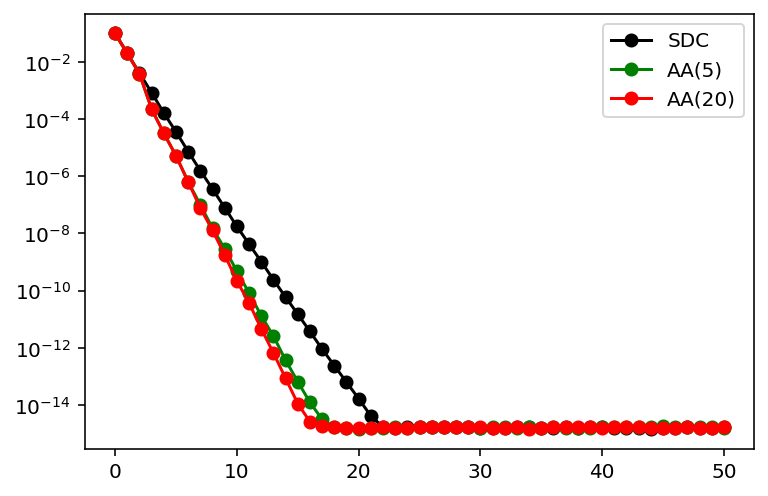

In [39]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 7$

In [40]:
delta = 7
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

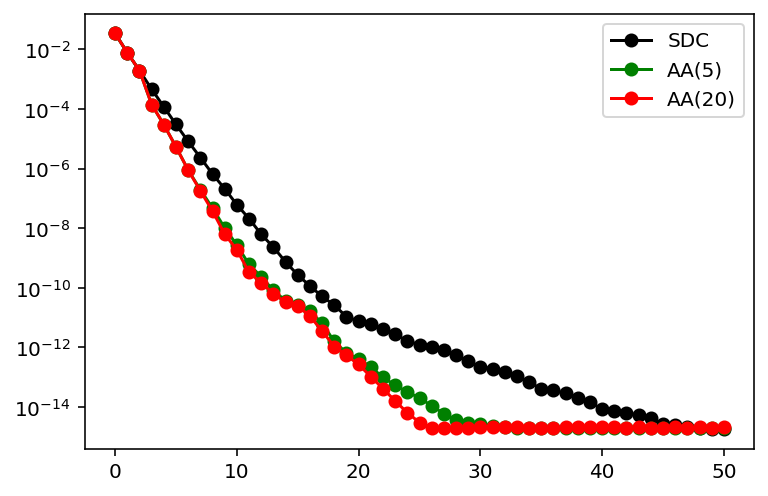

In [41]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 20$

In [42]:
delta = 20
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(100):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 100, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 100, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

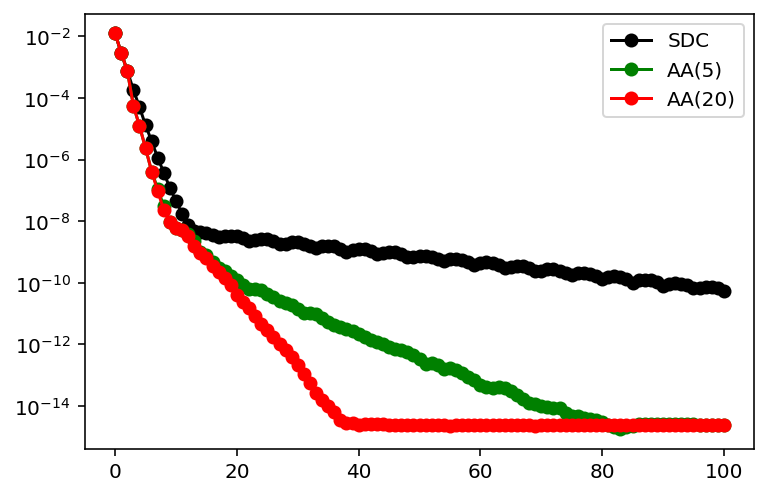

In [43]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 100$

Presimably, the problem with SDC is that it lacks L-stability. Check this.

In [44]:
delta = 100
sigma = 1

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))

N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(100):
  values = Implicit_Euler_c.deferred_correction(values, F, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 100, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator(u0, F, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction(values, F, 100, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

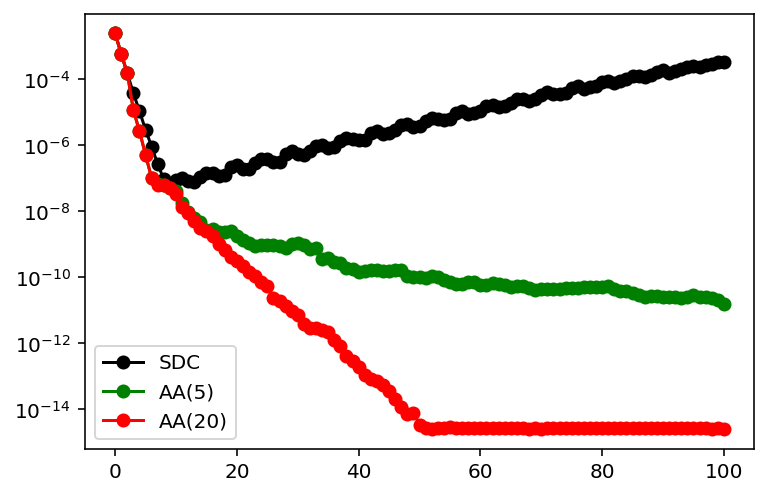

In [45]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

# Implicit Euler (without autograd)

## $\exp$

In [46]:
N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.exp(x)
F = jit(lambda u, t: jnp.stack([u[0], ], -1))
inv_dF = jit(lambda u, u_F, t, h: u_F / (1 - h*(t1-t0)/2))

exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

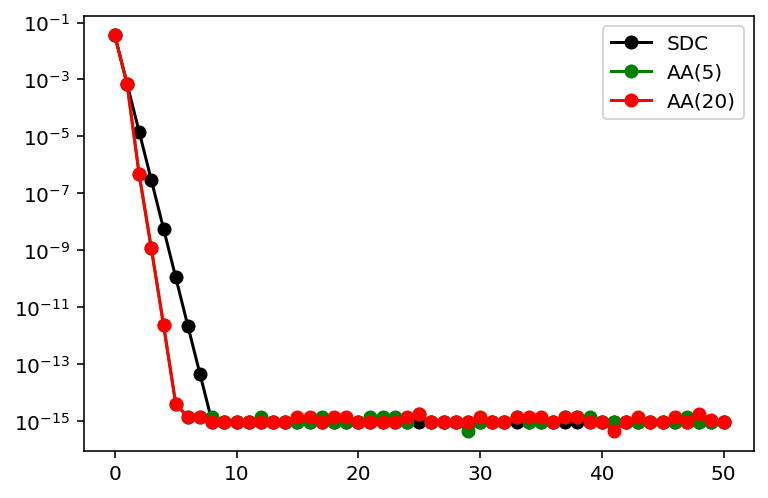

In [47]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## logistic equation

In [48]:
N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: 1 / (1 + jnp.exp(-x))
F = jit(lambda u, t: jnp.stack([u[0] * (1 - u[0]), ], -1))
inv_dF = jit(lambda u, u_F, t, h: u_F / (1 - h*(1-2*u)*(t1-t0)/2))

exact_solution = exact(t).reshape(-1, 1)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

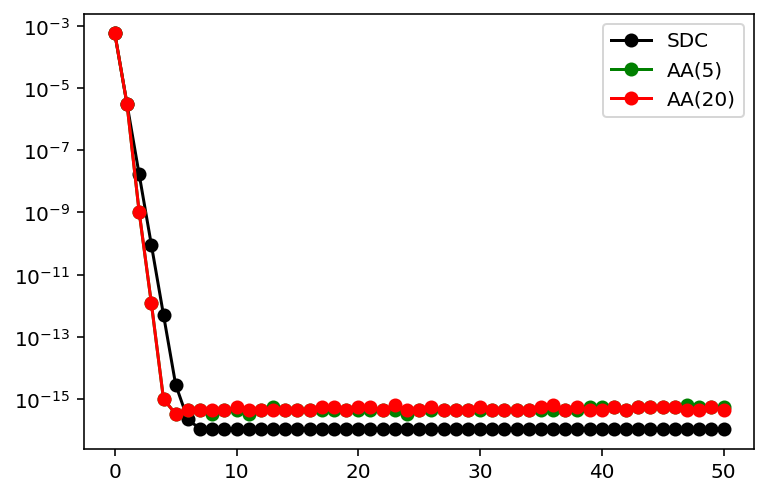

In [49]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## $\cos(\omega x)$

In [50]:
N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.stack([jnp.cos(2*jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x)], -1)
F = jit(lambda u, t: jnp.stack([u[1], -(2*jnp.pi)**2 * u[0]], -1))
inv_dF = jit(lambda u, u_F, t, h: jnp.stack([u_F[0] + h*u_F[1]*(t1 - t0)/2, -h*(2*jnp.pi)**2*u_F[0]*(t1 - t0)/2 + u_F[1]], -1) / (1 + (2*h*(t1 - t0)/2*jnp.pi)**2))

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

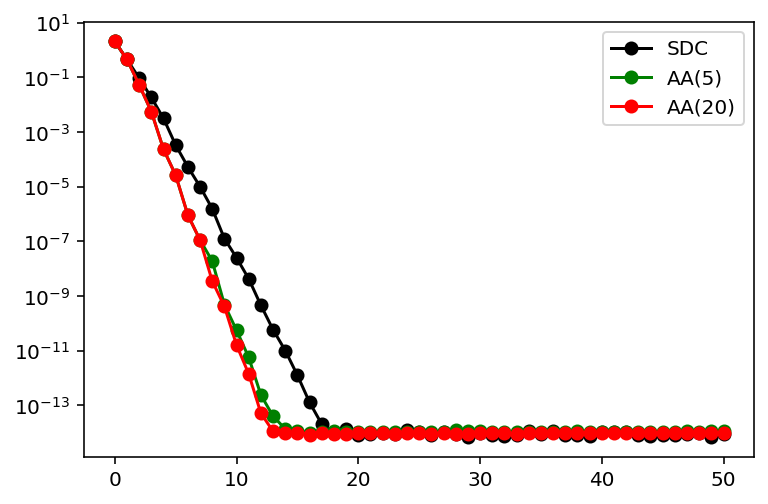

In [51]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

## Prothero–Robinson

\begin{equation}
  \dot{y}(t) = \dot{g}(t) + \delta (y(t) - g(t)),\,y(0)=\sigma\,g(t) = \sin(t)
\end{equation}

### $\delta = 0.1$

In [52]:
delta = 0.1
sigma = 1
N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

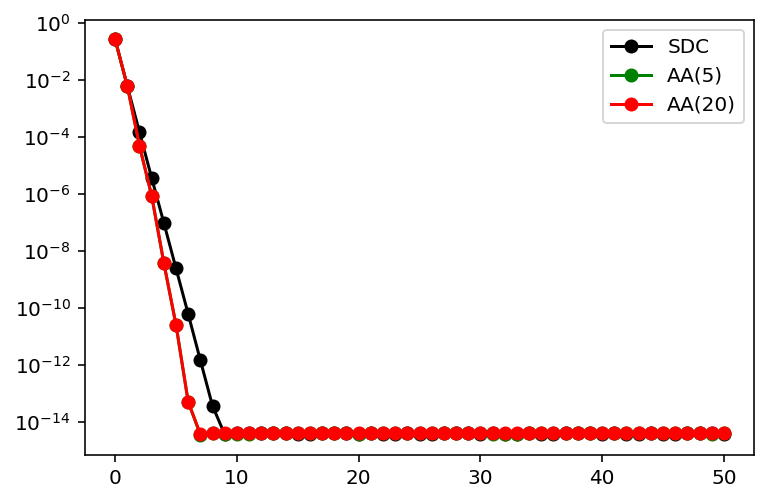

In [53]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 2$

In [54]:
delta = 2
sigma = 1
N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

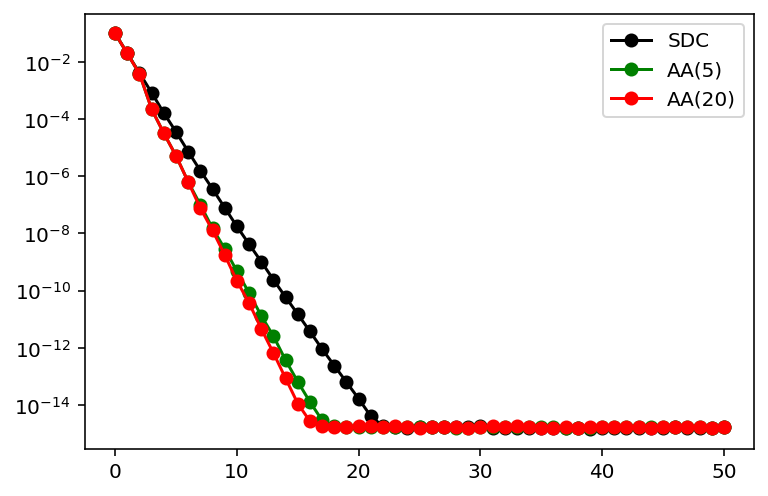

In [55]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 7$

In [56]:
delta = 7
sigma = 1
N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(50):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 50, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

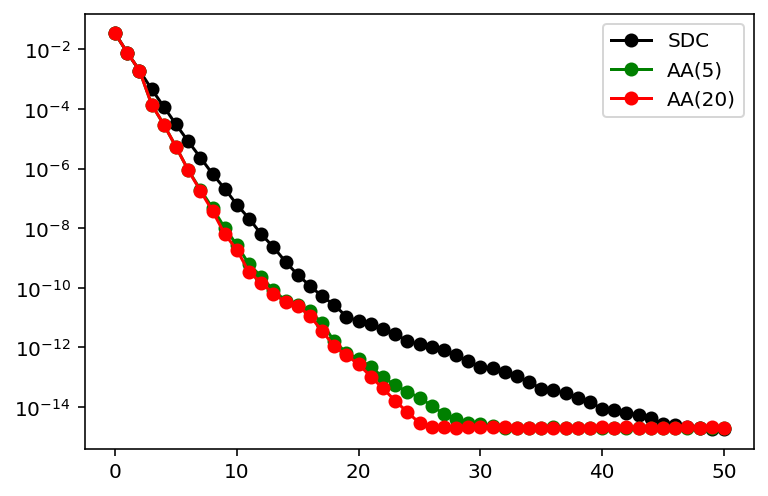

In [57]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 20$

In [58]:
delta = 20
sigma = 1
N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
E = [error,]

for i in range(100):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  E.append(error)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 100, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 100, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)

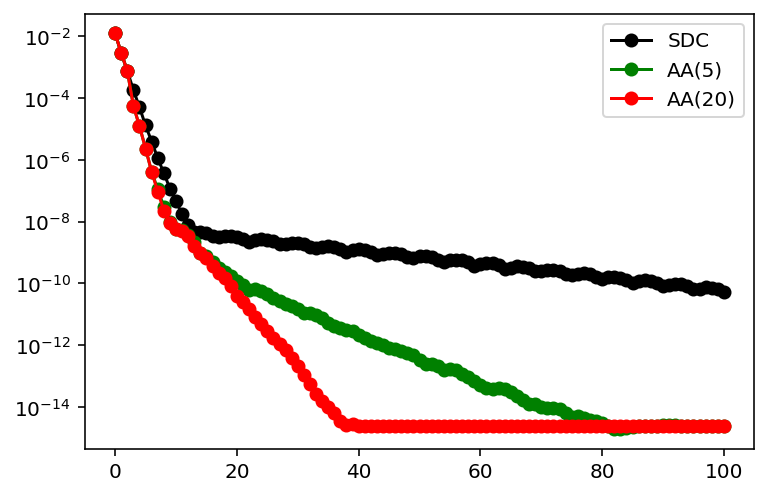

In [59]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 100$

In [60]:
delta = 100
sigma = 1
N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res, ]
E = [error,]

for i in range(100):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)
  E.append(error)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 100, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 100, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)
R2 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U, F, t0, t1)
R2 = jnp.linalg.norm(R2.reshape((R2.shape[0]*R2.shape[1], R2.shape[2])), axis=0)

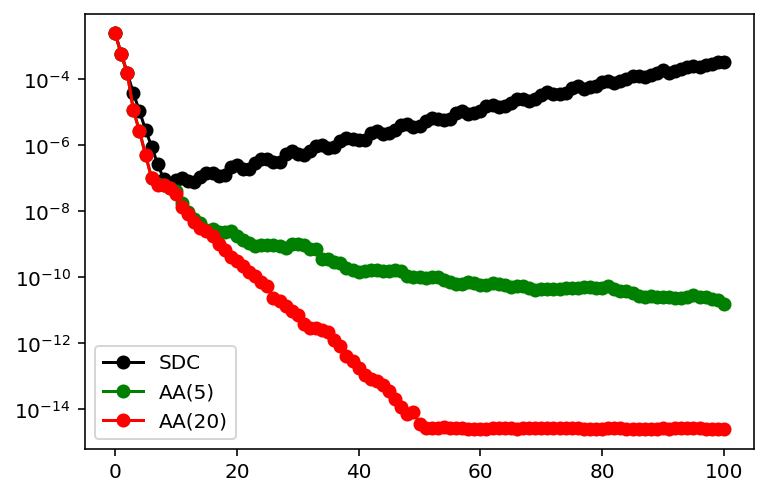

In [61]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

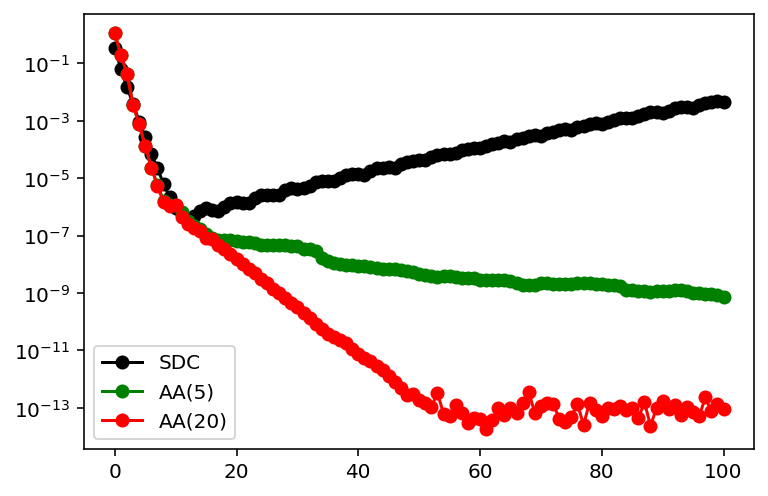

In [62]:
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(5)")
plt.plot(R1, "o-", color="red", label="AA(20)")
plt.legend();

### $\delta = 1000$

In [63]:
delta = 1000
sigma = 1
N_points = 50
t0, t1 = 0.0, 5*jnp.pi
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0

exact = lambda x: jnp.expand_dims(jnp.sin(x), -1)
F = jit(lambda u, t: jnp.stack([jnp.cos(t) - delta*(u[0] - jnp.sin(t)),], -1))
inv_dF = lambda u, u_F, t, h: u_F / (1 + h*delta*(t1-t0)/2)

exact_solution = exact(t)
u0 = exact_solution[0, :]

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)

error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res, ]
E = [error,]

for i in range(100):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  error = jnp.linalg.norm(jnp.ravel(values - exact_solution), ord=jnp.inf)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)
  E.append(error)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 100, 20, t0, t1, 1)
E_AA_20 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 100, 5, t0, t1, 1)
E_AA_5 = jnp.linalg.norm((U - jnp.expand_dims(exact_solution, -1)).reshape(exact_solution.shape[0]*exact_solution.shape[1], -1), ord=jnp.inf, axis=0)
R2 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U, F, t0, t1)
R2 = jnp.linalg.norm(R2.reshape((R2.shape[0]*R2.shape[1], R2.shape[2])), axis=0)

In [64]:
U.shape

(50, 1, 101)

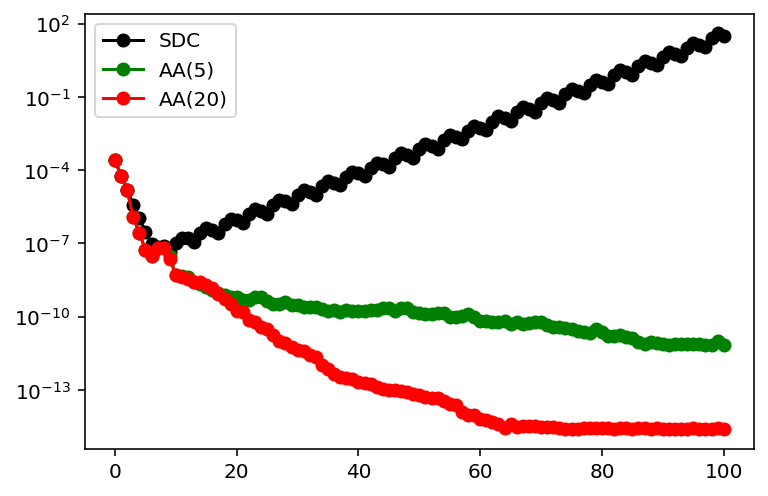

In [65]:
plt.yscale("log")
plt.plot(E, "o-", color="black", label="SDC")
plt.plot(E_AA_5, "o-", color="green", label="AA(5)")
plt.plot(E_AA_20, "o-", color="red", label="AA(20)")
plt.legend();

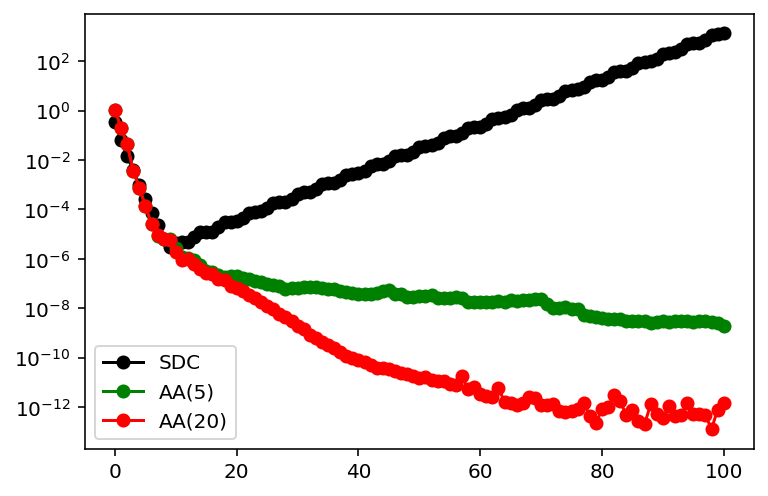

In [66]:
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(5)")
plt.plot(R1, "o-", color="red", label="AA(20)")
plt.legend();

## Van der Pol

### $\epsilon=0.1$

In [67]:
epsilon = 0.1
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 3.0])

@jit
def inv_dF(u, u_F, t, h):
  h_ = h*(t1-t0)/2
  det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
  u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
  u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
  return jnp.stack([u0, u1], -1)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res, ]

for i in range(30):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U1 = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 30, 20, t0, t1, 1)
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U1, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U2 = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 30, 5, t0, t1, 1)
R2 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U2, F, t0, t1)
R2 = jnp.linalg.norm(R2.reshape((R2.shape[0]*R2.shape[1], R2.shape[2])), axis=0)

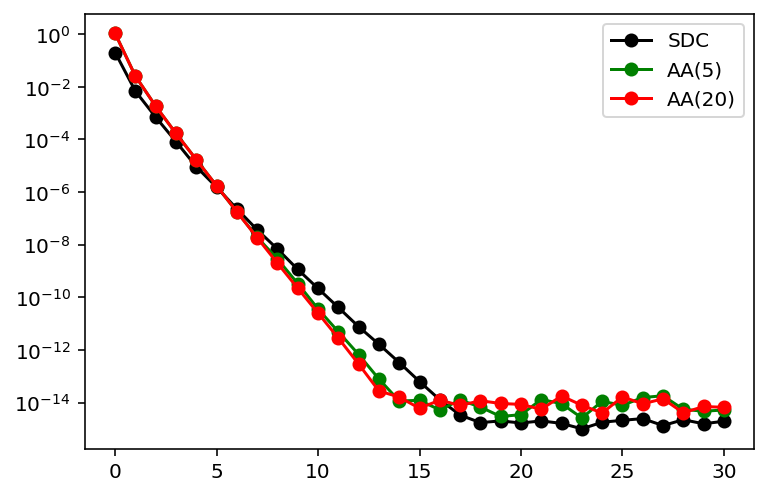

In [68]:
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(5)")
plt.plot(R1, "o-", color="red", label="AA(20)")
plt.legend();

### $\epsilon=0.01$

In [69]:
epsilon = 0.01
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

N_points = 50
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 1.0])

@jit
def inv_dF(u, u_F, t, h):
  h_ = h*(t1-t0)/2
  det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
  u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
  u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
  return jnp.stack([u0, u1], -1)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res, ]

for i in range(100):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U1 = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 100, 20, t0, t1, 1)
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U1, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U2 = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 100, 5, t0, t1, 1)
R2 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U2, F, t0, t1)
R2 = jnp.linalg.norm(R2.reshape((R2.shape[0]*R2.shape[1], R2.shape[2])), axis=0)

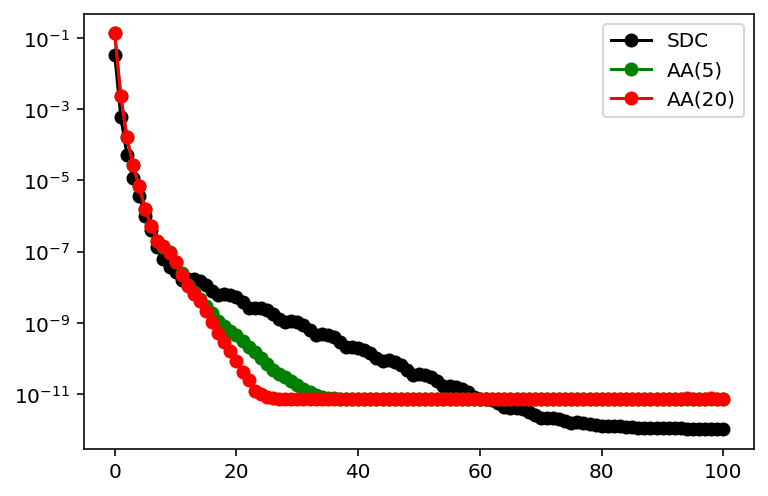

In [70]:
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(5)")
plt.plot(R1, "o-", color="red", label="AA(20)")
plt.legend();

### $\epsilon=0.001$

In [71]:
epsilon = 0.001
F = jit(lambda u, t: jnp.stack([u[1], (1 - u[1]*u[0]**2)/epsilon - u[0]], -1))

N_points = 100
t0, t1 = 0.0, 1.0
t = (t1 - t0) * (Chebyshev.Chebyshev_grid(N_points) + 1)/2 + t0
u0 = jnp.array([1.0, 1.0])

@jit
def inv_dF(u, u_F, t, h):
  h_ = h*(t1-t0)/2
  det = (1 + u[0]**2*h_/epsilon) + h_**2 * (2*u[0]*u[1]/epsilon + 1)
  u0 = ((1 + u[0]**2*h_/epsilon) * u_F[0] + h_ * u_F[1]) / det
  u1 = (u_F[1] - h_*(2*u[0]*u[1]/epsilon + 1) * u_F[0]) / det
  return jnp.stack([u0, u1], -1)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
R = [res, ]

for i in range(100):
  values = Implicit_Euler_c.deferred_correction_J(values, F, inv_dF, t0, t1, 1)
  res = jnp.linalg.norm(utils.residual(values, F, t0, t1), ord=jnp.inf)
  R.append(res)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U1 = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 100, 20, t0, t1, 1)
R1 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U1, F, t0, t1)
R1 = jnp.linalg.norm(R1.reshape((R1.shape[0]*R1.shape[1], R1.shape[2])), axis=0)

values = Implicit_Euler.integrator_J(u0, F, inv_dF, N_points, t0, t1, 1)
U2 = Implicit_Euler_c.AA_deferred_correction_J(values, F, inv_dF, 100, 5, t0, t1, 1)
R2 = vmap(utils.residual, in_axes=(2, None, None, None), out_axes=2)(U2, F, t0, t1)
R2 = jnp.linalg.norm(R2.reshape((R2.shape[0]*R2.shape[1], R2.shape[2])), axis=0)

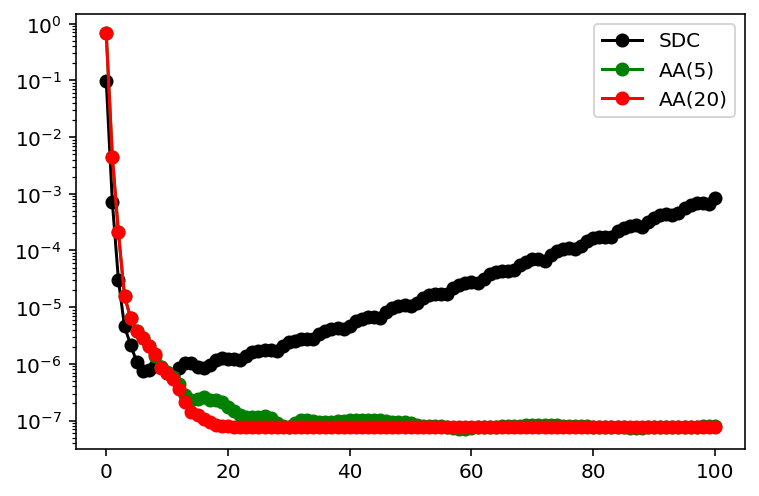

In [72]:
plt.yscale("log")
plt.plot(R, "o-", color="black", label="SDC")
plt.plot(R2, "o-", color="green", label="AA(5)")
plt.plot(R1, "o-", color="red", label="AA(20)")
plt.legend();